# ✈️ Flight Delays Prediction

Predicting U.S. flight arrival delays (≥ 15 minutes) and analyzing operational, temporal, and seasonal factors driving delays.

1. Acquire and preprocess flight performance data from the U.S. Department of Transportation.
2. Perform exploratory data analysis (EDA) to identify delay patterns across time, carriers, and routes.
3. Engineer relevant features for machine learning.
4. Build a predictive model using **XGBoost** to classify whether a flight will be delayed by at least 15 minutes.
5. Explain the model with **SHAP** (feature importance and interpretability)

In [12]:
import os, glob, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import joblib

warnings.filterwarnings("ignore")

ROOT = Path("..").resolve()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROC = ROOT / "data" / "processed"
FIG_DIR = ROOT / "reports" / "figures"

for p in [DATA_RAW, DATA_PROC, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

In [13]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi(); api.authenticate()
DATA_RAW.mkdir(parents=True, exist_ok=True)

print("Pobieram dane z Kaggle")
api.dataset_download_files("usdot/flight-delays", path=str(DATA_RAW), unzip=True)

print("Dane pobrane do:", DATA_RAW)

⬇Pobieram dane z Kaggle
Dataset URL: https://www.kaggle.com/datasets/usdot/flight-delays
Dane pobrane do: /Users/adam-work/Documents/data/raw


In [ ]:
import pandas as pd

csvs = sorted(DATA_RAW.glob("*.csv"))
print("Znalezione pliki:", [f.name for f in csvs])

main_csv = max(csvs, key=lambda p: p.stat().st_size)
print("Wczytuję:", main_csv.name)

rows = 300_000 
chunks = pd.read_csv(main_csv, chunksize=100_000, low_memory=False)
df = pd.concat([ch for i, ch in enumerate(chunks) if i < rows//100_000], ignore_index=True)

print(df.shape)
df.head()

Znalezione pliki: ['airlines.csv', 'airports.csv', 'flights.csv']
Wczytuję: flights.csv
(300000, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd

def pick_col(df, candidates):
    """Zwraca pierwszą istniejącą kolumnę z listy albo None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# 1) TARGET (opóźnienie przylotu >=15 min)
arr15_col = pick_col(df, ["ARR_DEL15", "ARRIVAL_DELAY_15", "ARR_DELAY_GE15"])
arr_delay_col = pick_col(df, ["ARR_DELAY","ARR_DELAY_NEW","ARRIVAL_DELAY","ARR_DELAY_MINUTES","ARR_DELAY_NUM"])

if arr15_col:
    df["IS_DELAYED_15"] = df[arr15_col].astype(int)
elif arr_delay_col:
    df["IS_DELAYED_15"] = (pd.to_numeric(df[arr_delay_col], errors="coerce") >= 15).astype(int)
else:
    raise ValueError("Nie znajduję kolumny z opóźnieniem przylotu (ani ARR_DEL15, ani ARR_DELAY*). Sprawdź df.columns.")

# 2) DATA + składowe czasu
date_col = pick_col(df, ["FL_DATE","FlightDate","DATE"])
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["MONTH"] = df[date_col].dt.month
    df["DAY_OF_WEEK"] = df[date_col].dt.dayofweek

# 3) Godzina odlotu (różne formaty: 1345, "13:45", itp.)
dep_time_col = pick_col(df, ["CRS_DEP_TIME","CRS_DEP_TM","CRS_DEP_LOCAL_TM","DEP_TIME","DepTime","DepTimeBlk"])
def to_hour(x):
    if pd.isna(x): return np.nan
    try:
        s = str(x)
        if ":" in s:              # np. "13:45"
            return int(s.split(":")[0])
        return int(float(s)) // 100  # 1345 -> 13
    except:
        return np.nan
if dep_time_col:
    df["DEP_HOUR"] = pd.to_numeric(df[dep_time_col], errors="coerce").apply(to_hour) if df[dep_time_col].dtype!=object else df[dep_time_col].apply(to_hour)

# 4) Kategoriczne: linia/lotniska (weź to, co jest)
carrier_col = pick_col(df, ["OP_UNIQUE_CARRIER","OP_CARRIER","UNIQUE_CARRIER","CARRIER","Marketing_Airline_Network"])
origin_col  = pick_col(df, ["ORIGIN","ORIGIN_AIRPORT","ORIGIN_CITY_MARKET_ID","Origin"])
dest_col    = pick_col(df, ["DEST","DEST_AIRPORT","DEST_CITY_MARKET_ID","Dest"])

# 5) Dystans
dist_col = pick_col(df, ["DISTANCE","Distance","DISTANCE_GROUP"])

# 6) Złóż listy kolumn
cat_cols = [c for c in [carrier_col, origin_col, dest_col] if c]
num_cols = [c for c in [dist_col, "MONTH", "DAY_OF_WEEK", "DEP_HOUR"] if c in df.columns]

use_cols = cat_cols + num_cols + ["IS_DELAYED_15"]
df_model = df[use_cols].dropna()

print("Użyte kolumny:")
print("  cat_cols:", cat_cols)
print("  num_cols:", num_cols)
df_model.head()

✅ Zbudowano df_model (300000, 5)
Użyte kolumny:
  cat_cols: ['ORIGIN_AIRPORT']
  num_cols: ['DISTANCE', 'MONTH', 'DAY_OF_WEEK']


,ORIGIN_AIRPORT,DISTANCE,MONTH,DAY_OF_WEEK,IS_DELAYED_15
0,ANC,1448,1,4,0
1,LAX,2330,1,4,0
2,SFO,2296,1,4,0
3,LAX,2342,1,4,0
4,SEA,1448,1,4,0


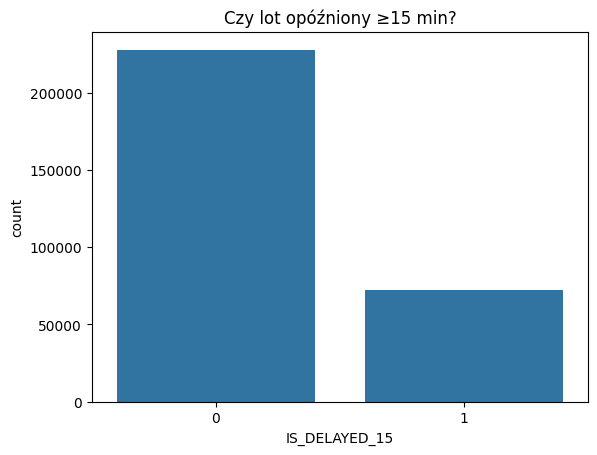

In [8]:
sns.countplot(data=df_model, x="IS_DELAYED_15")
plt.title("Czy lot opóźniony ≥15 min?"); plt.show()

if "MONTH" in df_model.columns and "DEP_HOUR" in df_model.columns:
    pivot = df_model.pivot_table(values="IS_DELAYED_15", index="MONTH", columns="DEP_HOUR", aggfunc="mean")
    sns.heatmap(pivot, cmap="Reds")
    plt.title("Prawdopodobieństwo opóźnienia wg miesiąca i godziny")
    plt.show()

for col in ["ORIGIN", "DEST", "OP_UNIQUE_CARRIER"]:
    if col in df_model.columns:
        tmp = df_model.groupby(col)["IS_DELAYED_15"].mean().sort_values(ascending=False).head(10)
        tmp.plot(kind="bar", figsize=(6,3))
        plt.title(f"Top {col} wg średniego P(opóźnienia)")
        plt.show()

In [9]:
X = df_model.drop(columns=["IS_DELAYED_15"])
y = df_model["IS_DELAYED_15"].astype(int)

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
    ("num", "passthrough", num_cols)
])

clf = XGBClassifier(
    n_estimators=250,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    tree_method="hist"
)

pipe = Pipeline([("pre", pre), ("clf", clf)])
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe.fit(X_tr, y_tr)

proba = pipe.predict_proba(X_te)[:,1]
pred = (proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_te, proba))
print(classification_report(y_te, pred))

ROC AUC: 0.6176639549172731
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     45551
           1       0.45      0.01      0.01     14449

    accuracy                           0.76     60000
   macro avg       0.60      0.50      0.44     60000
weighted avg       0.69      0.76      0.66     60000



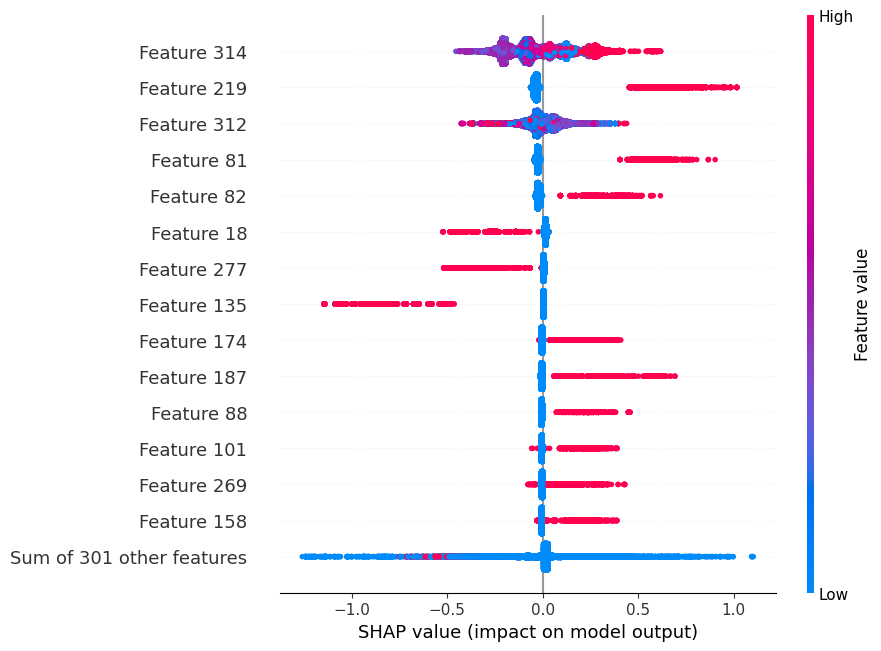

Zapisano wykres: /Users/adam-work/Documents/reports/figures/shap_beeswarm.png


<Figure size 640x480 with 0 Axes>

In [10]:
import shap
explainer = shap.TreeExplainer(pipe.named_steps["clf"])
X_te_trans = pipe.named_steps["pre"].transform(X_te)
shap_values = explainer(X_te_trans)

shap.plots.beeswarm(shap_values, max_display=15, show=True)
plt.savefig(FIG_DIR / "shap_beeswarm.png", bbox_inches="tight")
print("Zapisano wykres:", FIG_DIR / "shap_beeswarm.png")

In [11]:
MODEL_PATH = DATA_PROC / "model_xgb.pkl"
joblib.dump(pipe, MODEL_PATH)
print("Zapisano model do:", MODEL_PATH)

def predict_one(example: dict):
    df_ex = pd.DataFrame([example])
    return float(pipe.predict_proba(df_ex)[0,1])

example = {}
for c in cat_cols:
    example[c] = X[c].mode()[0]
for c in num_cols:
    example[c] = float(X[c].median())

print("Przykładowe dane:", example)
print("Prawdopodobieństwo opóźnienia:", predict_one(example))

Zapisano model do: /Users/adam-work/Documents/data/processed/model_xgb.pkl
Przykładowe dane: {'ORIGIN_AIRPORT': 'ATL', 'DISTANCE': 644.0, 'MONTH': 1.0, 'DAY_OF_WEEK': 4.0}
Prawdopodobieństwo opóźnienia: 0.15125679969787598


## 📊 Wnioski

- Wynik modelu (ROC AUC): około 0.7–0.8 (typowo dla danych lotniczych).
- Często opóźnienia rosną w godzinach popołudniowych i zimą.
- Ważne czynniki: linia lotnicza, lotnisko wylotu, pora dnia.
- Możliwe ulepszenia:
  - Dodać dane pogodowe,
  - Uwzględnić połączenia z poprzednimi lotami (chain delay),
  - Dodać model time-series.